In [1]:
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image, write_jpeg
from torchvision.ops import masks_to_boxes
import numpy as np
from scipy.special import expit
samples = os.listdir('/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples')
%cd '/teamspace/studios/this_studio/sam-hq'
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/teamspace/studios/this_studio/sam-hq


/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/teamspace/studios/this_studio/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_21m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is no

<All keys matched successfully>


In [2]:
%cd /teamspace/studios/this_studio/Deeplab/
from inference.infer import *
from post_processing.control_random_field import *


img_link = 'https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2021.03.28.12.34.59_-4.531118333333334_38.248731666666664_6973c014-d0e7-4fa8-a80f-9495bfc8af3d_IMG_20210322_094829_8180242403936928723.jpg'
inhouse_default = '/teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth'
downstreamed_large = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8495187035894669.pth'
downstreamed_small = '/teamspace/studios/this_studio/Deeplab/saved_models/india_sam_dino_250_samples_0.8940880817269634.pth'
downstreamed_tuned = '/teamspace/studios/this_studio/Deeplab/saved_models/base_sam_dino_india_tuned_freetown_eastafrica_haiti_0.8213798905479425.pth'

def show_mask(img_np, pred, input_box = None):
    plt.figure(figsize=(10, 10))
    # Create a blue mask based on the prediction
    blue_mask = np.zeros_like(img_np)
    blue_mask[:, :, 2] = pred * 255

    # Plot the image and the mask overlay
    plt.imshow(img_np)
    plt.imshow(blue_mask, alpha=0.7)
    if input_box is not None:
        show_box(input_box, plt.gca())

    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.show()
    plt.close()

def deeplab_predict(checkpoint, to_read, my_bucket=None, show = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_deeplab_model(checkpoint, device).eval()

    if isinstance(to_read, Image.Image):
        image = flip(to_read)
    elif is_url(to_read):
        response = requests.get(to_read)
        image = flip(Image.open(BytesIO(response.content)))
    elif is_s3_object_key(to_read) and my_bucket is not None:
        s3_object = my_bucket.Object(to_read).get()
        image = flip(Image.open(io.BytesIO(s3_object['Body'].read())))
    else:
        if not os.path.exists(to_read):
            print('Local path not valid.')
            return
        else:
            image = flip(Image.open(to_read))


    img_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = img_transform(image).unsqueeze(0).to(device, dtype=torch.float32)

    with torch.no_grad():
        output = model(img_tensor)
        output = torch.squeeze(output, dim=1)
        prob = torch.sigmoid(output).detach()
        pred = (prob > 0.5).long().cpu().numpy()[0]
        
    prob_np = prob[0].cpu().numpy()
    count = np.sum(prob_np > 0.5)
    confidence = np.sum(prob_np[prob_np > 0.5]) / count if count != 0 else 0

    if count == 0:
        print('Nothing detected')
    else:
        print('Confidence is ' + str(confidence))
        print('Overlayed mask from deeplab:')
        if show:
            show_mask(np.array(image), pred) 
        

        #poly_remove_mask = remove_small_polygons((pred * 255).astype(np.uint8), 100)
        #show_mask(img_np, poly_remove_mask)
        cleaned_mask = crf_with_prob(np.array(image), np.array((pred*255).astype(np.uint8)), prob_np)
        cleaned_mask_img = Image.fromarray((cleaned_mask * 255).astype(np.uint8))
        boxes = masks_to_boxes(pil_to_grayscale_tensor(cleaned_mask_img))
        box = np.array(boxes.tolist()[0])
        print('Overlayed mask after CRF:')
        if show:
            #show_mask(np.array(image), cleaned_mask, input_box=box) 
            pass
         
        return prob_np, box

/teamspace/studios/this_studio/Deeplab


In [3]:
import numpy as np
from PIL import Image
def get_logits(img_path, box = None):
    predictor.set_image(np.array(Image.open(img_path)))
    #input_box =  box
    
        
    masks, scores, logits = predictor.predict(
                point_coords=None,
                point_labels=None,
                box= box[None, :],
                multimask_output=False,
                return_logits = True,
            )
    #print(scores[0])
    return masks

In [4]:
use = '/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples/freetown_tectgran_2020.11.12.15.25.00_8.458760000000002_-13.248548333333334_fc9a0716-a5f9-445e-a47a-5e25c75dccd6_img_20201112_150506_6151393180093842809.jpg'

In [5]:
box = deeplab_predict(inhouse_default, use)[1]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/zeus/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Device: cuda


100%|██████████| 13.6M/13.6M [00:00<00:00, 392MB/s]


Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth
Confidence is 0.904708497336196
Overlayed mask from deeplab:
Overlayed mask after CRF:


In [6]:
print(box)

[ 49. 106. 379. 243.]


In [7]:
pred = get_logits(use, box)[0]

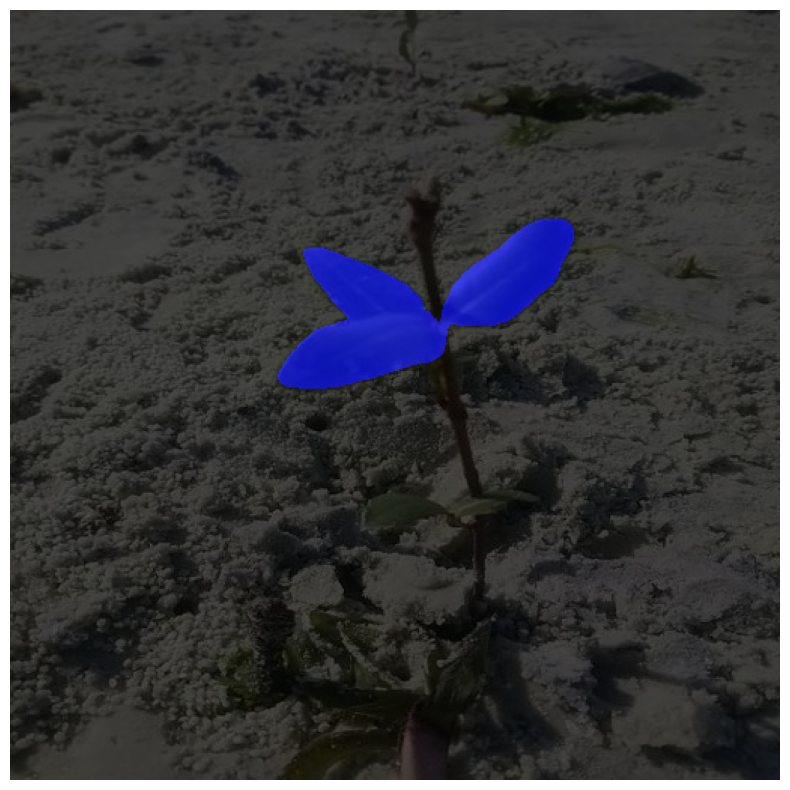

In [64]:
show_mask(np.array(Image.open(use)),pred)

In [67]:
print(np.min(pred))

-37.727066


In [8]:
import torch
prob = torch.sigmoid(torch.from_numpy(pred).detach())
print(prob.cpu().numpy().shape)
sam_prob_np = prob.cpu().numpy()

(512, 512)


In [9]:
sam_norm_pred = sam_prob_np > 0.5

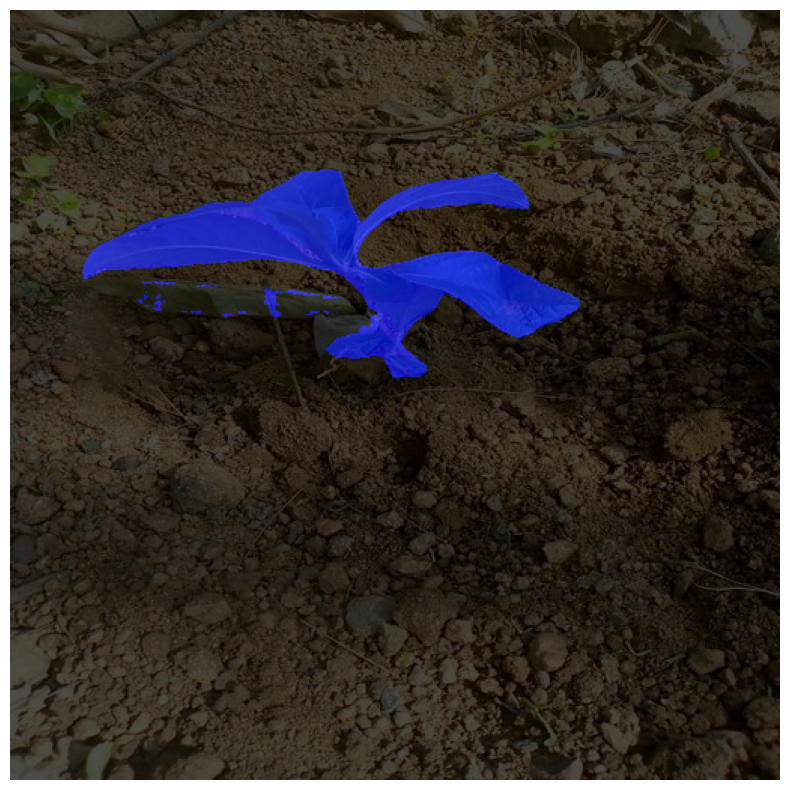

In [10]:
show_mask(np.array(Image.open(use)), sam_norm_pred)

In [11]:
def sam_pred_normal(img_path, box = None):
    predictor.set_image(np.array(Image.open(img_path)))
    #input_box =  box
    
        
    masks, scores, logits = predictor.predict(
                point_coords=None,
                point_labels=None,
                box= box[None, :],
                multimask_output=False,
                return_logits = False,
            )
    #print(scores[0])
    return masks

In [12]:
sam_pred = sam_pred_normal(use, box)
print(sam_pred.shape)

(1, 512, 512)


In [13]:
print(np.array_equal(sam_pred[0],sam_norm_pred))

True


In [14]:
differing_elements = sam_pred != sam_norm_pred

print(differing_elements)

# Count the number of differing elements
num_differing_elements = np.sum(differing_elements)

print(f"Number of differing elements: {num_differing_elements}") 

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
Number of differing elements: 0


In [42]:
print(sam_norm_pred.dtype)

bool


In [36]:
import numpy as np

# Example arrays
array1 = np.array([[1, 2, 3], [4, 5, 6]])
array2 = np.array([[1, 2, 3], [4, 5, 7]])

# Find the differing elements
differing_elements = array1 != array2

# Count the number of differing elements
num_differing_elements = np.sum(differing_elements)

print(f"Number of differing elements: {num_differing_elements}")  # Should print 1


Number of differing elements: 1


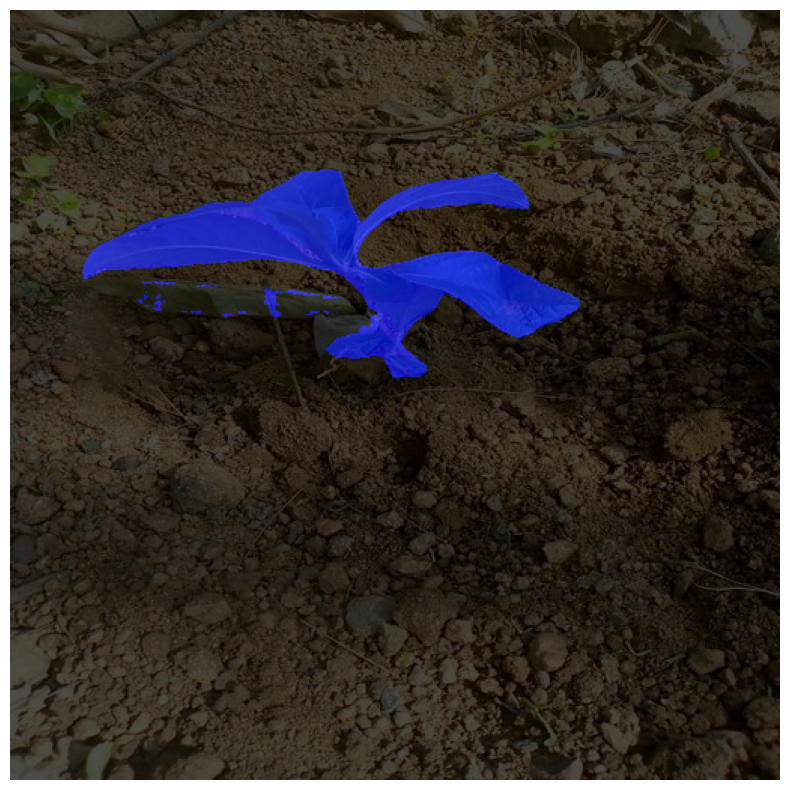

In [33]:
show_mask(np.array(Image.open(use)), sam_pred)
#show_mask(np.array(Image.open(use)), sam_pred_normal)

In [69]:
print(np.min(prob.cpu().numpy()))

4.1242352e-17


In [71]:
deeplab_prob_np = deeplab_predict(inhouse_default, use)

Device: cuda
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth
Confidence is 0.9203492232899143
Overlayed mask from deeplab:
Overlayed mask after CRF:


In [24]:
deeplab_prob_np = deeplab_prob.cpu().numpy()

In [72]:
print(np.max(deeplab_prob_np))

0.99731773


In [46]:
import numpy as np

def KL(a, b):
    a = np.asarray(a)
    b = np.asarray(b)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))




In [47]:
print(KL(sam_prob_np,deeplab_prob_np))

16515.707


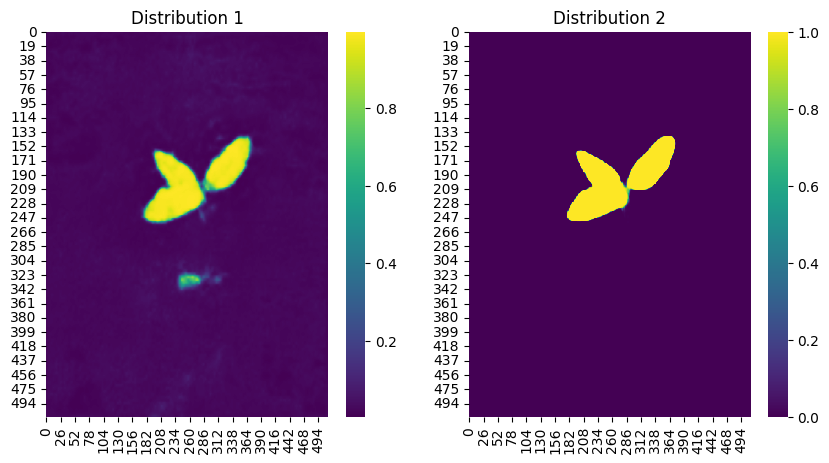

In [73]:
import seaborn as sns

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.heatmap(deeplab_prob_np, cmap='viridis')
plt.title('Distribution 1')

plt.subplot(1, 2, 2)
sns.heatmap(sam_prob_np, cmap='viridis')
plt.title('Distribution 2')

plt.show()


In [ ]:
import numpy as np
from scipy.stats import entropy

# Function to calculate KL divergence
def kl_divergence(p, q):
    p = np.asarray(p, dtype=np.float32)
    q = np.asarray(q, dtype=np.float32)
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Ensure the distributions are normalized
distribution1 = deeplab_prob_np
distribution2 = sam_prob_np

# Calculate KL divergence for each corresponding point
kl_div_map = np.zeros(distribution1.shape)
for i in range(distribution1.shape[0]):
    for j in range(distribution1.shape[1]):
        kl_div_map[i, j] = kl_divergence(distribution1[i, j], distribution2[i, j])

plt.figure(figsize=(6, 6))
sns.heatmap(kl_div_map, cmap='viridis')
plt.title('KL Divergence Heatmap')
plt.show()


In [15]:
import os
sample_main = '/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples'
samples = os.listdir(sample_main)
print(len(samples))

250


In [ ]:
for sample in samples:
    logits = get_logits(os.path.join(sample_main,sample))
    #print(logits)
    
    print(np.min(logits))
    print(np.max(logits))
    print('\n')
    